In [2]:
#Import my dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

# from alpha_vantage import alpha_vantage.timeseries
from alpha_vantage.timeseries import TimeSeries
api_key = 'S7MZO4XSG71DN2NB'

import os
import tensorflow as tf

Using TensorFlow backend.


In [3]:
ts = TimeSeries(key=api_key,output_format='pandas')
ticker = 'NASDAQ:INTC'

In [4]:
# Get the raw dataset
orig_dataset, meta_df = ts.get_daily(symbol=ticker, outputsize='full')

In [5]:
orig_dataset.columns = ['open', 'high', 'low', 'close', 'volume']
orig_dataset.head(3)
orig_dataset.shape

(5034, 5)

In [8]:
# Data cleaning
print('Checking for null values')
orig_dataset.isna().any()

Checking for null values


open      False
high      False
low       False
close     False
volume    False
dtype: bool

In [9]:
# setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

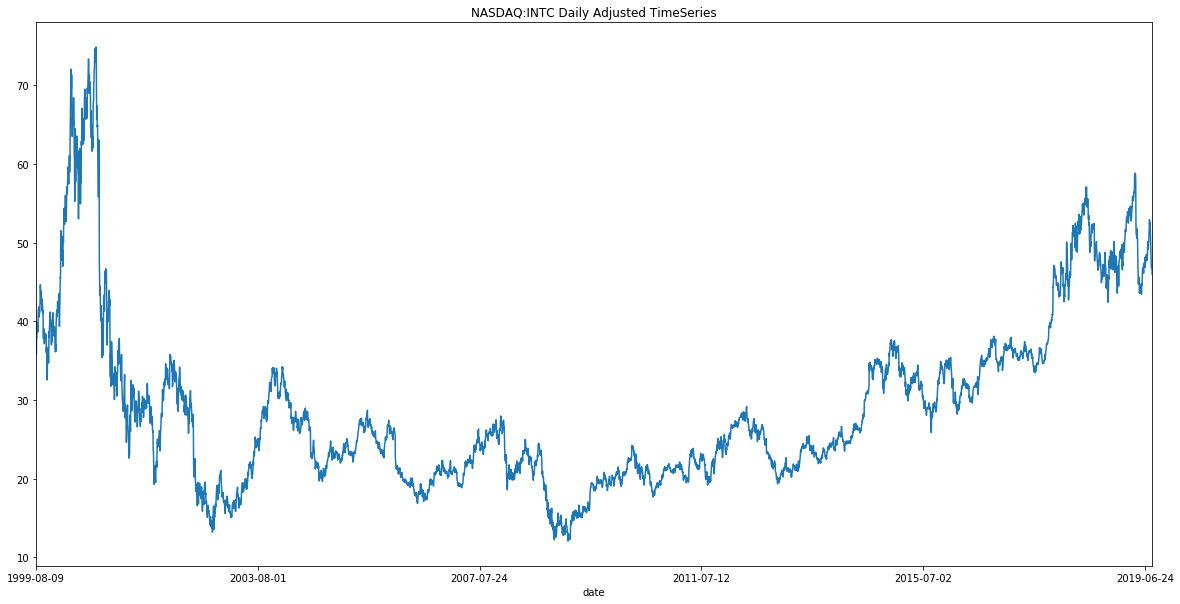

In [10]:
# plot the dataset
orig_dataset['close'].plot()
plt.title(f'{ticker} Daily Adjusted TimeSeries')
plt.show()

In [9]:
# Look at volume
#plt.figure()
#plt.plot(dataset["volume"])
#plt.title(f'{ticker} stock volume history')
#plt.ylabel('Volume')
#plt.xlabel('Days')
#plt.show()

In [11]:
# Create data frame tu use to extract traing, test data
df = orig_dataset['close'].values
df = df.reshape(-1,1)
print(df.shape)


(5034, 1)


array([[36.7188],
       [35.875 ],
       [38.    ],
       [37.9688],
       [39.875 ],
       [39.2813],
       [39.5   ]])

In [13]:
orig_dataset['close'].tail(10)

date
2019-07-29    52.510
2019-07-30    51.700
2019-07-31    50.550
2019-08-01    49.500
2019-08-02    48.680
2019-08-05    46.970
2019-08-06    46.960
2019-08-07    46.730
2019-08-08    47.170
2019-08-09    45.985
Name: close, dtype: float64

In [12]:
arr = np.array(df[:-11:-1])
reversed_arr = arr[::-1]
reversed_arr

array([[52.51 ],
       [51.7  ],
       [50.55 ],
       [49.5  ],
       [48.68 ],
       [46.97 ],
       [46.96 ],
       [46.73 ],
       [47.17 ],
       [45.985]])

In [14]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-60:])
print(dataset_train.shape)
print(dataset_test.shape)

(4027, 1)
(1067, 1)


In [18]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:7]

array([[0.39236882],
       [0.37893144],
       [0.41277172],
       [0.41227486],
       [0.44263078],
       [0.43317621],
       [0.43665897]])

In [19]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:7]

array([[0.3329883 ],
       [0.33967673],
       [0.33553627],
       [0.33903973],
       [0.3419062 ],
       [0.34031372],
       [0.33474003]])

In [20]:
# converting dataset into x_train and y_train
def create_dataset(df):
    x = []
    y = []
    for i in range(60,df.shape[0]):
        x.append(df[i-60:i,0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [21]:
x_train, y_train = create_dataset(dataset_train)
x_train[:1]

array([[0.39236882, 0.37893144, 0.41277172, 0.41227486, 0.44263078,
        0.43317621, 0.43665897, 0.43267776, 0.42322319, 0.44412453,
        0.46801178, 0.46950394, 0.4739836 , 0.45308225, 0.46850864,
        0.46253683, 0.46203997, 0.47199299, 0.48692253, 0.5187722 ,
        0.50533482, 0.49189904, 0.50633012, 0.50334422, 0.47945696,
        0.49090373, 0.46850864, 0.46552273, 0.48144757, 0.4769695 ,
        0.46054622, 0.46701648, 0.42471534, 0.41015845, 0.4301903 ,
        0.42471534, 0.40630305, 0.39933593, 0.40431245, 0.42073413,
        0.41426547, 0.42023728, 0.40978581, 0.41028426, 0.41675293,
        0.41824668, 0.38191735, 0.39162194, 0.37196433, 0.3600207 ,
        0.32618043, 0.36450036, 0.37843459, 0.39236882, 0.37495023,
        0.37644398, 0.36051915, 0.3824158 , 0.42421849, 0.41277172]])

In [22]:
y_train[:1]

array([0.42471534])

In [23]:
x_test, y_test = create_dataset(dataset_test)
x_test[:1]

array([[0.3329883 , 0.33967673, 0.33553627, 0.33903973, 0.3419062 ,
        0.34031372, 0.33474003, 0.34445418, 0.34923163, 0.3563978 ,
        0.34763914, 0.33744725, 0.32884784, 0.32215941, 0.31467474,
        0.30607532, 0.30527908, 0.31435624, 0.31483398, 0.30639382,
        0.30750856, 0.31148977, 0.31642647, 0.32327415, 0.31833745,
        0.32136317, 0.31865594, 0.31578947, 0.31706346, 0.30161637,
        0.29158372, 0.29206147, 0.28823951, 0.29429095, 0.28601003,
        0.28378056, 0.27741062, 0.26833347, 0.27215543, 0.28107333,
        0.27979935, 0.28043634, 0.28378056, 0.27693288, 0.27104069,
        0.26498925, 0.26323752, 0.26307827, 0.25447886, 0.25909706,
        0.26881121, 0.26960745, 0.26801497, 0.26865196, 0.27024445,
        0.27151843, 0.27135918, 0.26960745, 0.26753722, 0.2796401 ]])

In [24]:
#reshaping for LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
print(x_train.shape)
print(x_test.shape)

(3967, 60, 1)
(1007, 60, 1)


In [25]:
tf.logging.set_verbosity(tf.logging.ERROR)
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 96)            37632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 96)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 96)            74112     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 96)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_3 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 97        
Total para

In [27]:
model.compile(loss='mean_squared_error', optimizer ='adam')

In [249]:
if(not os.path.exists('./outputs/stock_prediction.h5')):
    model.fit(x_train, y_train, epochs=100, batch_size=32)
    model.save('./outputs/stock_prediction.h5')
else:
    model = load_model('./outputs/stock_prediction.h5')
    

Epoch 1/100
3967/3967 [==============================] - 9s 2ms/step - loss: 3.2042e-04
Epoch 2/100
3967/3967 [==============================] - 8s 2ms/step - loss: 2.6167e-04
Epoch 3/100
3967/3967 [==============================] - 8s 2ms/step - loss: 2.9992e-04
Epoch 4/100
3967/3967 [==============================] - 8s 2ms/step - loss: 2.8391e-04
Epoch 5/100
3967/3967 [==============================] - 8s 2ms/step - loss: 2.6259e-04
Epoch 6/100
3967/3967 [==============================] - 9s 2ms/step - loss: 2.8310e-04
Epoch 7/100
3967/3967 [==============================] - 9s 2ms/step - loss: 2.5693e-04
Epoch 8/100
3967/3967 [==============================] - 9s 2ms/step - loss: 2.4793e-04
Epoch 9/100
3967/3967 [==============================] - 10s 2ms/step - loss: 2.6655e-04
Epoch 10/100
3967/3967 [==============================] - 10s 2ms/step - loss: 2.5930e-04
Epoch 11/100
3967/3967 [==============================] - 9s 2ms/step - loss: 2.9042e-04
Epoch 12/100
3967/3967 [====

In [250]:
x_test

array([[[0.3329883 ],
        [0.33967673],
        [0.33553627],
        ...,
        [0.26960745],
        [0.26753722],
        [0.2796401 ]],

       [[0.33967673],
        [0.33553627],
        [0.33903973],
        ...,
        [0.26753722],
        [0.2796401 ],
        [0.26897046]],

       [[0.33553627],
        [0.33903973],
        [0.3419062 ],
        ...,
        [0.2796401 ],
        [0.26897046],
        [0.27677363]],

       ...,

       [[0.5204236 ],
        [0.52695278],
        [0.53411896],
        ...,
        [0.58284895],
        [0.55561749],
        [0.55545824]],

       [[0.52695278],
        [0.53411896],
        [0.53268572],
        ...,
        [0.55561749],
        [0.55545824],
        [0.55179553]],

       [[0.53411896],
        [0.53268572],
        [0.52249383],
        ...,
        [0.55545824],
        [0.55179553],
        [0.55880245]]])

range(4017, 5024)


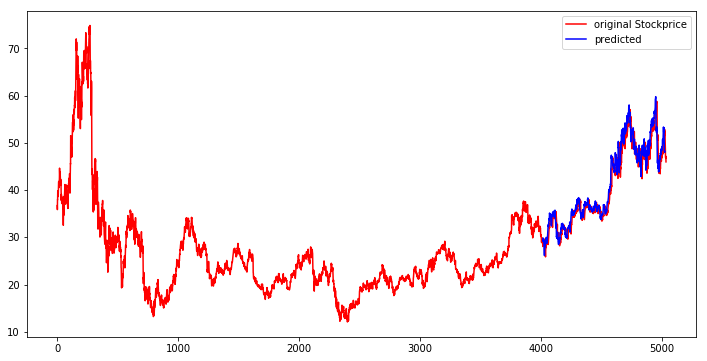

In [251]:
# visualize the predictions
%matplotlib inline
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(df, color='red', label='original Stockprice')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)),predictions,color='blue', label='predicted')
plt.legend()
print(range(len(y_train)+50, len(y_train)+50+len(predictions)))

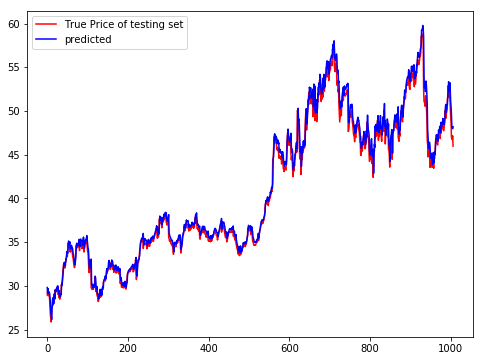

In [252]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(y_test_scaled, color='red', label = 'True Price of testing set')
plt.plot(predictions, color = 'blue', label='predicted')

plt.legend()

In [253]:
orig_dataset.tail(10)

,open,high,low,close,volume
date,,,,,
2019-07-29,51.53,52.560,50.78,52.510,21897500.0
2019-07-30,51.71,52.310,51.56,51.700,16487700.0
2019-07-31,51.51,51.720,50.05,50.550,24169800.0
2019-08-01,50.52,51.890,49.47,49.500,34020800.0
2019-08-02,49.09,49.360,48.50,48.680,27881600.0
2019-08-05,47.76,47.960,46.57,46.970,38936600.0
2019-08-06,47.15,47.560,46.77,46.960,26119600.0
2019-08-07,46.30,46.880,45.97,46.730,29356800.0
2019-08-08,46.16,47.365,45.91,47.170,26722550.0


In [267]:
orig_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5034 entries, 1999-08-09 to 2019-08-09
Data columns (total 5 columns):
open      5034 non-null float64
high      5034 non-null float64
low       5034 non-null float64
close     5034 non-null float64
volume    5034 non-null float64
dtypes: float64(5)
memory usage: 236.0+ KB


In [254]:
orig_arr = np.array(df[:-11:-1])
orig_reversed_arr = orig_arr[::-1]
orig_reversed_arr

array([[52.51 ],
       [51.7  ],
       [50.55 ],
       [49.5  ],
       [48.68 ],
       [46.97 ],
       [46.96 ],
       [46.73 ],
       [47.17 ],
       [45.985]])

In [255]:
pred_arr = np.array(predictions[:-11:-1])
pred_reversed_arr = pred_arr[::-1]
pred_reversed_arr

array([[52.26392 ],
       [53.251892],
       [52.404922],
       [51.17256 ],
       [50.52573 ],
       [49.648243],
       [48.143734],
       [48.13825 ],
       [47.981182],
       [48.20879 ]], dtype=float32)

In [256]:
# percentdiff = ((val1-val2)/((val1+val2)/2))*100
# percentdiff

In [257]:
new_df = orig_dataset.copy()
new_df = new_df.reset_index()
new_df.shape

(5034, 6)

In [258]:
new_df = new_df.iloc[-10:]
new_df.shape

(10, 6)

In [259]:
new_df = new_df[['date','close']]


In [260]:
#new_df.set_index('date', inplace=True)

In [261]:
new_df

,date,close
5024,2019-07-29,52.510
5025,2019-07-30,51.700
5026,2019-07-31,50.550
5027,2019-08-01,49.500
5028,2019-08-02,48.680
5029,2019-08-05,46.970
5030,2019-08-06,46.960
5031,2019-08-07,46.730
5032,2019-08-08,47.170
5033,2019-08-09,45.985


In [262]:
tmp_date = new_df['date']
tmp_date

5024    2019-07-29
5025    2019-07-30
5026    2019-07-31
5027    2019-08-01
5028    2019-08-02
5029    2019-08-05
5030    2019-08-06
5031    2019-08-07
5032    2019-08-08
5033    2019-08-09
Name: date, dtype: object

In [268]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 5024 to 5033
Data columns (total 2 columns):
date     10 non-null object
close    10 non-null float64
dtypes: float64(1), object(1)
memory usage: 244.0+ bytes


In [263]:
#data = {'actual close':orig_reversed_arr, 'predicted close':pred_reversed_arr}

percent_diff = pd.DataFrame({'close':orig_reversed_arr[:,0], 'pred':pred_reversed_arr[:,0]})

In [264]:
mask = ((percent_diff['close'] - percent_diff['pred']) / ((percent_diff['close'] + percent_diff['pred'])/2))*100
mask
percent_diff['percent difference'] = mask.round(2)
percent_diff

,close,pred,percent difference
0,52.510,52.263920,0.47
1,51.700,53.251892,-2.96
2,50.550,52.404922,-3.60
3,49.500,51.172562,-3.32
4,48.680,50.525730,-3.72
5,46.970,49.648243,-5.54
6,46.960,48.143734,-2.49
7,46.730,48.138248,-2.97
8,47.170,47.981182,-1.71
9,45.985,48.208790,-4.72


In [265]:
((46.970-50.077579)/((46.970+50.077579)/2))*100

-6.404238069658598

In [266]:
new_df.merge(percent_diff, on='close').set_index('date')

,close,pred,percent difference
date,,,
2019-07-29,52.510,52.263920,0.47
2019-07-30,51.700,53.251892,-2.96
2019-07-31,50.550,52.404922,-3.60
2019-08-01,49.500,51.172562,-3.32
2019-08-02,48.680,50.525730,-3.72
2019-08-05,46.970,49.648243,-5.54
2019-08-06,46.960,48.143734,-2.49
2019-08-07,46.730,48.138248,-2.97
2019-08-08,47.170,47.981182,-1.71
